In [1]:

# 1. Import necessary libraries
import numpy as np  # for numerical operations
import pandas as pd  # for handling dataframes
import matplotlib.pyplot as plt  # for visualizations
import seaborn as sns  # advanced visualization
from sklearn.preprocessing import LabelEncoder  # for encoding categorical labels
from sklearn.model_selection import train_test_split  # for splitting data
from sklearn.naive_bayes import MultinomialNB  # classification model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score  # evaluation metrics
from wordcloud import WordCloud  # to visualize frequent words
from collections import Counter  # count most common words
import nltk  # natural language toolkit for text processing
import string  # for punctuation removal
from nltk.corpus import stopwords  # for stopword removal
from nltk.stem.porter import PorterStemmer  # for stemming



In [2]:
# 2. Load the data
df = pd.read_csv("/content/spam.csv", encoding="latin1")  # load CSV file

In [6]:
# 3. Inspect data
df.sample(5)  # see 5 random rows

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
221,ham,There is os called ubandu which will run witho...,NaN,NaN,NaN
957,ham,Welp apparently he retired,NaN,NaN,NaN
4481,ham,What do u reckon as need 2 arrange transport i...,NaN,NaN,NaN
192,ham,Hi :)finally i completed the course:),NaN,NaN,NaN
3580,ham,Ard 4 lor...,NaN,NaN,NaN


In [7]:
# 4. Check shape of data
df.shape  # see rows and columns

(5572, 5)

In [8]:
# 5. Drop unnecessary columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)


In [9]:
# 6. Rename columns for clarity
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [10]:
# 7. Encode the target column (ham/spam -> 0/1)
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])


In [11]:
# 8. Check for missing values
df.isnull().sum()


,0
target,0
text,0


In [12]:
# 9. Remove duplicates
df = df.drop_duplicates(keep='first')

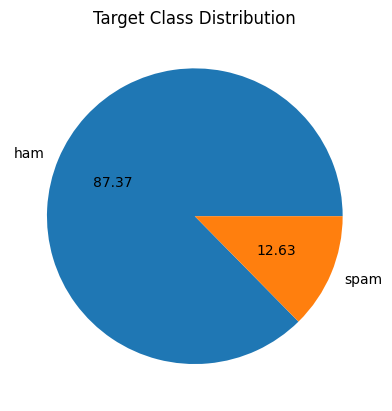

In [13]:

# 10. Visualize class distribution
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.title("Target Class Distribution")
plt.show()


In [14]:
# 11. Add basic text features (number of characters, number of words)
df['num_chars'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(x.split()))


In [15]:
# 12. Describe those features
df[['num_chars', 'num_words']].describe()

,num_chars,num_words
count,5169.000000,5169.000000
mean,78.977945,15.340685
std,58.236293,11.068488
min,2.000000,1.000000
25%,36.000000,7.000000
50%,60.000000,12.000000
75%,117.000000,22.000000
max,910.000000,171.000000


In [20]:
# 13. Download nltk resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [18]:
# 14. Define a powerful transform_text function
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()  # lowercase
    text = nltk.word_tokenize(text)  # tokenize

    # remove non-alphanumeric and stopwords
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]

    # stemming
    text = [ps.stem(word) for word in text]

    return " ".join(text)

In [21]:
# 15. Apply text transformation
df['transformed_text'] = df['text'].apply(transform_text)


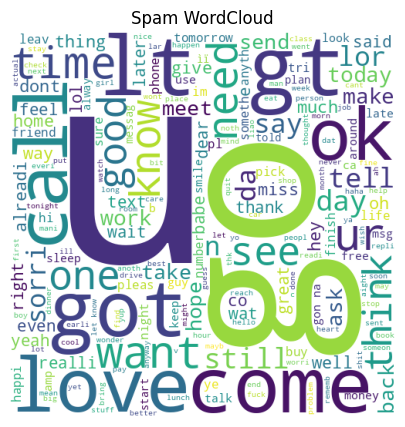

In [25]:
# 16. WordCloud visualization
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(10,5))
plt.imshow(spam_wc)
plt.axis('off')
plt.title("Spam WordCloud")
plt.show()


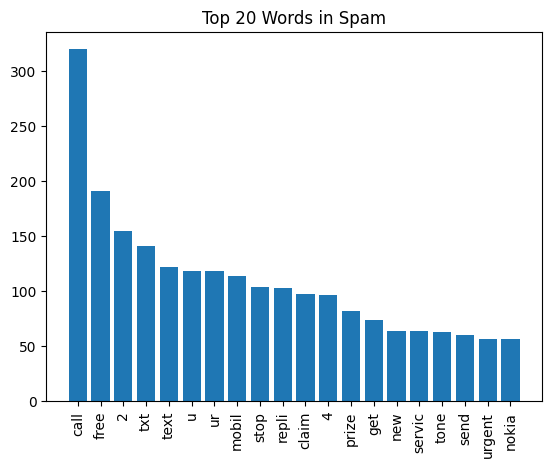

In [26]:
# 17. Most common words in spam and ham
spam_words = []
for msg in df[df['target'] == 1]['transformed_text']:
    spam_words.extend(msg.split())

ham_words = []
for msg in df[df['target'] == 0]['transformed_text']:
    ham_words.extend(msg.split())

# show top 20 frequent spam words
plt.bar(*zip(*Counter(spam_words).most_common(20)))
plt.title("Top 20 Words in Spam")
plt.xticks(rotation=90)
plt.show()

In [27]:
# 18. Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values


In [30]:
# 19. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# 20. Model training with MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

In [32]:
# 21. Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

Accuracy: 0.9729206963249516
Confusion Matrix:
 [[888   1]
 [ 27 118]]
Precision: 0.9915966386554622


In [33]:
# 22. Save vectorizer and model
import pickle
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))